In [35]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf
from tensorflow import keras
import pandas
import datetime
from datetime import date
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('C:\\src\\stockPredictor\\SpyHist.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = [d.date() for d in df['DateTime']]
df['time'] = [d.time() for d in df['DateTime']]
df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['slowsma'] = df['Close'].rolling(21).mean()
df['fastsma'] = df['Close'].rolling(9).mean()
df['Difference'] = df['Close'] - df['Open']
df = df.dropna()

for currentDate in df.date.unique():
    if len(df.date.unique()) > len(df.loc[df['date'] == currentDate]):
        df = df.loc[df['date'] != currentDate]

new_day_data = pd.read_csv('C:\\src\\stockPredictor\\dailySpy.csv')
new_day_data['DateTime'] = pd.to_datetime(new_day_data['DateTime'])
new_day_data['date'] = [d.date() for d in new_day_data['DateTime']]
new_day_data['time'] = [d.time() for d in new_day_data['DateTime']]
new_day_data['Open'] = new_day_data['Open'].astype(float)
new_day_data['Close'] = new_day_data['Close'].astype(float)
new_day_data['Volume'] = new_day_data['Volume'].astype(int)
new_day_data['slowsma'] = new_day_data['Close'].rolling(21).mean()
new_day_data['fastsma'] = new_day_data['Close'].rolling(9).mean()
new_day_data['Difference'] = new_day_data['Close'] - new_day_data['Open']



scaler = MinMaxScaler()

df[['Difference', 'Volume', 'slowsma', 'fastsma']] = scaler.fit_transform(df[['Difference', 'Volume', 'slowsma', 'fastsma']])

maxSteps = len(df.time.unique())

In [36]:
count = 0

for i in range(1, maxSteps):
    # Create sequences of past and future data
    X = []
    y = []

    for currentDate in df.date.unique():
        past_sequence = df[['Difference','slowsma','fastsma','Volume']].loc[df['date']==currentDate][0:i]
        future_sequence = df[['Difference']][df['date']==currentDate][i:maxSteps]
        X.append(past_sequence)
        y.append(future_sequence)

    X = np.array(X)
    y = np.array(y)
    
    # Define the model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(i, 4)))
    model.add(BatchNormalization())
    model.add(Dense(maxSteps - i))
    optimizer = Adam(clipnorm=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
    # Train the model (you can adjust the number of epochs and batch size)
    model.fit(X, y, epochs=100, callbacks=[early_stopping])

    modelName = 'model_'+str(df.time.unique()[i-1]).replace(':','_')+'.keras'
    print(modelName)
    model.save(modelName)


Epoch 1/100
3/3 [==============================] - 1s 3ms/step - loss: 0.2601
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2545
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2486
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2422
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2355
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2282
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2202
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2116
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 0.2023
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1924
Epoch 11/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1820
Epoch 12/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1711
Epoch 13/100
3/3 [==============================] - 0s 2ms/st

In [13]:
X

array([[0., 0., 0., 0.]])

In [4]:
new_model = tf.keras.models.load_model('model_09_55_00.keras')

,Unnamed: 0,Open,Close,date,time,Difference,scalars
DateTime,,,,,,,
2023-05-30 09:30:00-04:00,0,422.03,422.40,2023-05-30,09:30:00,0.37,0.602180
2023-05-30 09:35:00-04:00,1,422.41,422.09,2023-05-30,09:35:00,-0.32,0.414169
2023-05-30 09:40:00-04:00,2,422.09,421.75,2023-05-30,09:40:00,-0.34,0.408719
2023-05-30 09:45:00-04:00,3,421.77,421.76,2023-05-30,09:45:00,-0.01,0.498638
2023-05-30 09:50:00-04:00,4,421.77,421.18,2023-05-30,09:50:00,-0.59,0.340599
...,...,...,...,...,...,...,...
2023-09-20 15:35:00-04:00,6079,439.53,439.29,2023-09-20,15:35:00,-0.24,0.435967
2023-09-20 15:40:00-04:00,6080,439.29,439.18,2023-09-20,15:40:00,-0.11,0.471390
2023-09-20 15:45:00-04:00,6081,439.19,439.39,2023-09-20,15:45:00,0.20,0.555858


In [18]:
# Generate predictions for a given input sequence (39 past ticks)
testdata=new_day_data[0:7]
X = np.array(testdata['scalars'])
input_sequence = X.reshape(1, len(testdata), 1)
predicted_sequence = scaler.inverse_transform(new_model.predict(input_sequence))

1/1 [==============================] - 0s 14ms/step


In [19]:
dfTotal = pandas.DataFrame(columns=['Total','Time'])
Total = 0
count = 0

for currentTime in df.time.unique():
    if(testdata.loc[testdata['time']==currentTime].empty is False):
        Total = Total + testdata.loc[testdata['time']==currentTime]['Difference'].values[0]
    else:
        Total = Total + predicted_sequence[0][count]
        count = count + 1
    timeObj = datetime.datetime.strptime(currentTime, '%H:%M:%S').time()
    dfTotal.loc[len(dfTotal.index)] = [Total,timeObj] 

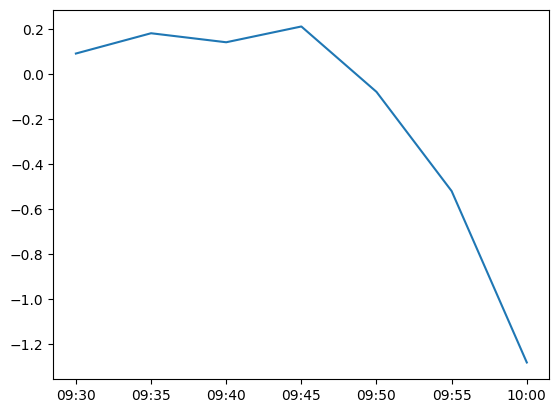

In [20]:
datetimes = [datetime.datetime.combine(datetime.date.today(), t) for t in dfTotal["Time"]]
xformatter = mdates.DateFormatter('%H:%M')
plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.show()

In [7]:
input_sequence

array([[[0.52588556],
        [0.52588556],
        [0.49046322],
        [0.52043597],
        [0.42234332],
        [0.38147139],
        [0.29427793],
        [0.49046322],
        [0.50681199],
        [0.53950954],
        [0.51771117],
        [0.49591281],
        [0.373297  ],
        [0.373297  ],
        [0.5613079 ],
        [0.47683924],
        [0.47138965],
        [0.48501362],
        [0.52043597],
        [0.53133515],
        [0.53950954],
        [0.43051771],
        [0.48228883],
        [0.59400545],
        [0.51226158],
        [0.50408719],
        [0.4359673 ],
        [0.49591281],
        [0.49591281],
        [0.5613079 ],
        [0.4386921 ],
        [0.44414169],
        [0.55585831],
        [0.53678474],
        [0.46321526],
        [0.49046322],
        [0.46049046],
        [0.43051771],
        [0.52043597],
        [0.47956403],
        [0.56675749]]])

In [35]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(dfTotal)

# Resets the options
pd.reset_option('all')

C:\Users\tmcna\AppData\Local\Temp\ipykernel_14156\3039856532.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Total,Time
0,0.360000,09:30:00
1,0.340000,09:35:00
2,-0.190000,09:40:00
3,-0.320000,09:45:00
4,-0.090000,09:50:00
5,-0.040000,09:55:00
6,-0.020000,10:00:00
7,0.270000,10:05:00
8,0.250000,10:10:00
9,0.430000,10:15:00


c:\Python39\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\Python39\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [26]:
dfAverage = pandas.DataFrame(columns=['Average','Time'])
currentAve = 0
count = len(df.date.unique())

for currentTime in df.time.unique():
    average = 0
    for currentDate in df.date.unique():
        if(df.loc[(df['time'] == currentTime) & (df['date'] == currentDate)].empty is False):
            average = average + df.loc[(df['time'] == currentTime) & (df['date'] == currentDate)]['Close'].values[0]-df.loc[(df['time'] == currentTime) & (df['date'] == currentDate)]['Open'].values[0]
        else:
            print(currentDate)
    currentAve = currentAve + (average/count)
    dfAverage.loc[len(dfAverage.index)] = [currentAve,currentTime] 



In [33]:

currentAve = 0
for currentTime in dfAverage.Time.unique():
    currentAve = currentAve + dfAverage.loc[(dfAverage['Time'] == currentTime)]['Average'].values[0]
print(currentAve)

13.972784810126504


In [49]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from tensorflow import keras
from time import sleep
from datetime import datetime, date, timedelta, time
from sklearn.preprocessing import MinMaxScaler
import threading
from decimal import *

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.data = [] #Initialize variable to store candle

    def historicalData(self, reqId, bar):
        print(bar)

    def historicalDataUpdate(self, reqId, bar):
        print(bar)

    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextorderId = orderId
        print('The next valid order id is: ', self.nextorderId)

    def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
        print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
    
    def openOrder(self, orderId, contract, order, orderState):
        print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)

    def execDetails(self, reqId, contract, execution):
        print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)
        
    def position(self, account: str, contract: Contract, position: Decimal, avgCost: float):
        super().position(account, contract, position, avgCost)
        print("Position.", "Account:", account, "Symbol:", contract.symbol, "SecType:", contract.secType, "Currency:", contract.currency,"Position:", decimalMaxString(position), "Avg cost:", floatMaxString(avgCost))
        
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7496, 126)


#Create contract object
contract = Contract()
contract.symbol = 'SPY'
contract.secType = 'STK'
contract.exchange = 'SMART'
contract.currency = 'USD'

#Start the socket in a thread
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()



app.reqHistoricalData(1, contract, '', '1 D', '5 mins', 'TRADES', 1, 2, True, [])
# app.reqPositions()

In [41]:
df = pd.DataFrame()
df.iloc[-1] = ['test']

ValueError: Must have equal len keys and value when setting with an iterable

In [50]:
app.disconnect()

Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 100 Avg cost: 433.31
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 100 Avg cost: 433.32
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 100 Avg cost: 433.32
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -100 Avg cost: 432.942
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -100 Avg cost: 432.92839146
Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: -100 Avg cost: 432.92839146
Position. Account: U11

ERROR -1 2104 Market data farm connection is OK:usopt


Position. Account: U11359296 Symbol: SPY SecType: STK Currency: USD Position: 0 Avg cost: 0
